# Photon Counting
1) Grab Data

2) Threshold Frames by 5*Read Noise

3) Sum frames along temporal dimension

4) Apply Nemati (2020) 3rd order photometric correction

5) Subtract background (avg of 6x6 pixels in the corner)

In [1]:
import numpy as np
import resample2D
def threshold(factor,readnoise,frame):
    
    thresh = factor*readnoise
    
    frame[frame<thresh] = 0
    frame[frame>thresh] = 1
    
    return frame

def photCorrPC(nobs,nfr,t,g):
    """
    Photon counting to 3rd order correction, typical parameters are
    nobs =  
    t = 5*100 e-/frame
    g = 6000 e-/photoelectron
    nbr = lam_br * Nfr * eth * ecl
    
    This should return the mean expected photon rate per-pixel
    
    
    """
    
    lam_est = -np.log(1-(nobs/nfr))*np.exp(t/g)
    lam_est -= deltaLam(lam_est,t,g,nfr,nobs)
    lam_est -= deltaLam(lam_est,t,g,nfr,nobs)
    
    return lam_est

def deltaLam(lam,t,g,nfr,nobs):
    """
    
    Parameters
    ----------
    lam : float
        mean expected rate per pixel per frame from photCorrPC
    t : float
        threshold chosen for photon counting
    g : float
        EM Gain
    nfr : float
        number of frames
    nobs : float
        sum of counts across all frames after thresholding
    
    From B. Nemati 7 Nov 2020
    
    Returns
    -------
    dlam
    
    """
    
    epsThr_a = np.exp(-t/g)*(t**2 * lam**2 + 2*g*t*lam*(3+lam) + 2*g**2 *(6+3*lam + lam**2))
    epsThr_b = (2*g**2 *(6+3*lam + lam**2))
    epsThr3  = epsThr_a/epsThr_b
    
    epsCL = (1-np.exp(lam))/lam
    func  = lam*nfr*epsThr3*epsCL - nobs
    
    dfdlam_a = (1/(2*g**2 *(6+3*lam+lam**2)))
    dfdlam_b = np.exp(-t/g - lam)*nfr
    dfdlam_c = 2*g**2 *(6+3*lam+lam**2)**2 + t**2 *lam*(-12 + 3*lam +3*lam**2 + lam**3 + 3*np.exp(lam)*(4+lam))
    dfdlam_d = 2*g*t*(-18 +6*lam +15*lam**2 + 6*lam**3 +lam**4 + 6*np.exp(lam)*(3+2*lam))
    
    dfdlam   = dfdlam_a*dfdlam_b*(dfdlam_c+dfdlam_d)
    
    dlam = func/dfdlam
    
    return dlam

In [ ]:
from astropy.io import fits
import matplotlib.pyplot as plt

# grab the fields with MUFs and the disk
pth = '/home/uasal-optics/Desktop/os9_hlc_muf/muf_os9_ccd_images_no_planets.fits'
disk = fits.getdata('/home/uasal-optics/Downloads/zodipic_10pc03mas._coremasked._HLC.fits').astype(float)

# Resample the disk to fit the HLC resolution
y = resample2D.resamp2D(disk,48/200)

# place disk in a 67 x 67 box
box = np.zeros([67,67])
box[int(67/2)-24:int(67/2)+24,int(67/2)-24:int(67/2)+24] = y

# Grab the MUFs
data = fits.getdata(pth).astype(float)

# add disk to frames
scalar = 1e14

plt.set_cmap('plasma')
plt.imshow(data[60],vmin=500,vmax=501)
plt.title('ID = 1 First Frame')
plt.colorbar()
plt.show()

plt.imshow(y*scalar)
plt.title('Resampled Disk with large scalar')
plt.colorbar()
plt.show()

plt.imshow(np.sum(data[60:1079,:,:],axis=0),vmin=500)
plt.title('ID = 1 Summed Frames w/o disk')
plt.colorbar()
plt.show()

# Add debris disk to each frame
for i in range(len(data[:,1,1])):
    
    data[i,:,:] += scalar*box

# Sum all frames
dataID2 = np.sum(threshold(5,100,data[60:1079]),axis=0)

plt.figure(figsize=[10,10])
plt.imshow(dataID2)
plt.title('Summed Maps ID = 1')
plt.colorbar()
plt.show()

In [ ]:
data = fits.getdata(pth).astype(float)
data_id2 = data[60:1079]
for i in range(len(data[60:1079,1,1])):
    data_id2[i,:,:] += scalar*box
data_t_id2 = threshold(5,100,data_id2)
data_s_id2 = np.sum(data_t_id2,axis=0)
data_c_id2 = photCorrPC(data_s_id2,1020,5,6000)/5
data_b_id2 = data_c_id2 - np.mean(data_c_id2[0:5,0:5])

plt.figure(figsize=[10,10])
plt.imshow(data_b_id2)
plt.title('Photon Counted - Background Subtracted with disk')
plt.colorbar()
plt.show()

## -11 Target Star

In [ ]:
from astropy.io import fits
import matplotlib.pyplot as plt

# Load data
data = fits.getdata(pth).astype(float)

# Add disk to frames
for i in range(len(data[60:1079,1,1])):
    data[i,:,:] += scalar*box
    
for i in range(len(data[60:1079,1,1])):
    data[i,:,:] += scalar*box
    
for i in range(len(data[60:1079,1,1])):
    data[i,:,:] += scalar*box
    
for i in range(len(data[60:1079,1,1])):
    data[i,:,:] += scalar*box
    
for i in range(len(data[60:1079,1,1])):
    data[i,:,:] += scalar*box
    
for i in range(len(data[60:1079,1,1])):
    data[i,:,:] += scalar*box

# Apply binary theshold of 5*read noise
data_t_id2 = threshold(5,100,data[60:1079])
data_t_id4 = threshold(5,100,data[2340:3601])
data_t_id9 = threshold(5,100,data[6006:7265])
data_t_id11 = threshold(5,100,data[8526:9785])
data_t_id14 = threshold(5,100,data[9911:10930])
data_t_id16 = threshold(5,100,data[12191:13450])
print('mean val = ',np.mean(data[60:1079]))

# Sum all binary frames along temporal axis
data_s_id2 = np.sum(data_t_id2,axis=0)
data_s_id4 = np.sum(data_t_id4,axis=0)
data_s_id9 = np.sum(data_t_id9,axis=0)
data_s_id11 = np.sum(data_t_id11,axis=0)
data_s_id14 = np.sum(data_t_id14,axis=0)
data_s_id16 = np.sum(data_t_id16,axis=0)

# Coincidence and Threshold Loss Correction
data_c_id2 = photCorrPC(data_s_id2,1020,5,6000)
data_c_id4 = photCorrPC(data_s_id4,1260,5,6000)
data_c_id9 = photCorrPC(data_s_id9,1260,5,6000)
data_c_id11 = photCorrPC(data_s_id11,1260,5,6000)
data_c_id14 = photCorrPC(data_s_id14,1020,5,6000)
data_c_id16 = photCorrPC(data_s_id16,1260,5,6000)

# Sum all frames
data_c_m11 = data_c_id2+data_c_id4+data_c_id9+data_c_id11+data_c_id14+data_c_id16

# Divide by exposure time
data_c_m11 = data_c_m11/(5)

# Subtract background
data_c_m11 = data_c_m11 - np.mean(data_c_m11[0:5,0:5])

plt.figure(figsize=[10,10])
plt.set_cmap('plasma')
plt.title('After iterative photometric correction [counts/s] (not normalized)')
plt.imshow(data_c_m11)
plt.colorbar()
plt.show()

1020
1262
1260
1260
1020
1260
1260
1259
1020
900
1260
1260
59
64
59
64
59
24


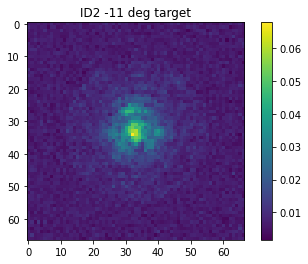

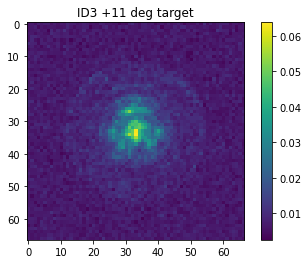

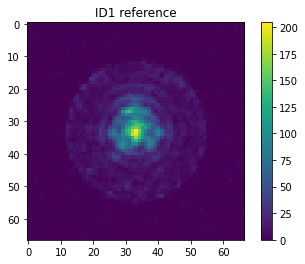

In [12]:
from astropy.io import fits
import matplotlib.pyplot as plt
pth = '/home/uasal-optics/Desktop/os9_hlc_muf/muf_os9_ccd_images_no_planets.fits'
# Load data
data = fits.getdata(pth).astype(float)
def processcube(data,ID):
    
    # image indices for each Star ID
    if ID == 1:
        mind = 0
        mand = 59
        frames = 60
        
    elif ID == 2:   
        mind = 60
        mand = 1079
        frames = 1020
        
    elif ID == 3:
        mind = 1080
        mand = 2339
        frames = 1260
        
    elif ID == 4:
        mind = 2340
        mand = 3601
        frames = 1260
        
    elif ID == 5:
        mind = 3602
        mand = 4860
        frames = 1260
        
    elif ID == 6:
        mind = 4861
        mand = 4925
        frames = 60
        
    elif ID == 7:
        mind = 4926
        mand = 4985
        frames = 60
        
    elif ID == 8:
        mind = 4986
        mand = 6005
        frames = 1020
        
    elif ID == 9:
        mind = 6006
        mand = 7265
        frames = 1260
        
    elif ID == 10:
        mind = 7626
        mand = 8525
        
    elif ID == 11:
        mind = 8526
        mand = 9785
        
    elif ID == 12:
        mind = 9786
        mand = 9850
        
    elif ID == 13:
        mind = 9851
        mand = 9910
        
    elif ID == 14:
        mind = 9911
        mand = 10930
        
    elif ID == 15:
        mind = 10931
        mand = 12190
        
    elif ID == 16:
        mind = 12191
        mand = 13450
        
    elif ID == 17:
        mind = 13451
        mand = 14710
        
    elif ID == 18:
        mind = 14711
        mand = 14735
        
    # Add debris disks
    disk = fits.getdata('/home/uasal-optics/Downloads/zodipic_10pc03mas._coremasked._HLC.fits').astype(float)
    
    # Resample the disk to fit the HLC resolution
    y = resample2D.resamp2D(disk,48/200)

    # place disk in a 67 x 67 box
    box = np.zeros([67,67])
    box[int(67/2)-24:int(67/2)+24,int(67/2)-24:int(67/2)+24] = y

    # add disk to frames
    scalar = 1e14
    
    # Add debris disk to each frame
    for i in range(mind,mand):

        data[i,:,:] += scalar*box

    data_t = threshold(5,100,data[mind:mand])
    data_s = np.sum(data_t,axis=0)
    data_c = photCorrPC(data_s,mand-mind+1,5,6000)/5
    
    data_c[data_c <= 0] = 0
    data_c[data_c == np.nan] = 0
    data_c[data_c == np.inf] = 0
#     data_c[]
    
    print(mand-mind+1)
    
    return data_c

def processref(data,ID):
    
    # image indices for each Star ID
    if ID == 1:
        mind = 0
        mand = 59
        frames = 60
        
    elif ID == 2:   
        mind = 60
        mand = 1079
        frames = 1020
        
    elif ID == 3:
        mind = 1080
        mand = 2339
        frames = 1260
        
    elif ID == 4:
        mind = 2340
        mand = 3601
        frames = 1260
        
    elif ID == 5:
        mind = 3602
        mand = 4860
        frames = 1260
        
    elif ID == 6:
        mind = 4861
        mand = 4925
        frames = 60
        
    elif ID == 7:
        mind = 4926
        mand = 4985
        frames = 60
        
    elif ID == 8:
        mind = 4986
        mand = 6005
        frames = 1020
        
    elif ID == 9:
        mind = 6006
        mand = 7265
        frames = 1260
        
    elif ID == 10:
        mind = 7626
        mand = 8525
        
    elif ID == 11:
        mind = 8526
        mand = 9785
        
    elif ID == 12:
        mind = 9786
        mand = 9850
        
    elif ID == 13:
        mind = 9851
        mand = 9910
        
    elif ID == 14:
        mind = 9911
        mand = 10930
        
    elif ID == 15:
        mind = 10931
        mand = 12190
        
    elif ID == 16:
        mind = 12191
        mand = 13450
        
    elif ID == 17:
        mind = 13451
        mand = 14710
        
    elif ID == 18:
        mind = 14711
        mand = 14735
    print(mand-mind)
    data_s = np.sum(data[mind:mand],axis=0)/(60*10)
    data_s -= np.mean(data_s[0:5,0:5])
    
    data_s[data_s <= 0] = 1e-12
    data_s[data_s == np.nan] = 1e-12
    data_s[data_s == np.inf] = 1e-12
    
    return data_s
    
        
    



# -11 Target
dataID2 = processcube(data,2)
dataID4 = processcube(data,4)
dataID9 = processcube(data,9)
dataID11 = processcube(data,11)
dataID14 = processcube(data,14)
dataID16 = processcube(data,16)

# +11 Target
dataID3 = processcube(data,3)
dataID5 = processcube(data,5)
dataID8 = processcube(data,8)
dataID10 = processcube(data,10)
dataID15 = processcube(data,15)
dataID17 = processcube(data,17)

# Reference Star
dataID1 = processref(data,1)
dataID6 = processref(data,6)
dataID7 = processref(data,7)
dataID12 = processref(data,12)
dataID13 = processref(data,13)
dataID18 = processref(data,18)

plt.figure()
plt.imshow(dataID2)
plt.title('ID2 -11 deg target')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(dataID3)
plt.title('ID3 +11 deg target')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(dataID1)
plt.title('ID1 reference')
plt.colorbar()
plt.show()
    
# # Apply binary threshold
# data_t_id3 = threshold(5,100,data[1080:2339])
# data_t_id5 = threshold(5,100,data[3602:4860])
# data_t_id8 = threshold(5,100,data[4986:6005])
# data_t_id10 = threshold(5,100,data[7626:8525])
# data_t_id15 = threshold(5,100,data[10931:12190])
# data_t_id17 = threshold(5,100,data[13451:14710])

# # Sum along temporal dimension
# data_s_id3 = np.sum(data_t_id3,axis=0)
# data_s_id5 = np.sum(data_t_id5,axis=0)
# data_s_id8 = np.sum(data_t_id8,axis=0)
# data_s_id10 = np.sum(data_t_id10,axis=0)
# data_s_id15 = np.sum(data_t_id15,axis=0)
# data_s_id17 = np.sum(data_t_id17,axis=0)

# # Iterative photometric correction & exposure time norm
# data_c_id3 = photCorrPC(data_s_id3,1260,5,6000)/5
# data_c_id5 = photCorrPC(data_s_id5,1260,5,6000)/5
# data_c_id8 = photCorrPC(data_s_id8,1020,5,6000)/5
# data_c_id10 = photCorrPC(data_s_id10,1260,5,6000)/5
# data_c_id15 = photCorrPC(data_s_id15,1260,5,6000)/5
# data_c_id17 = photCorrPC(data_s_id17,1260,5,6000)/5

# # Background correction
# data_c_id3 -= np.mean(data_c_id3[0:5,0:5])
# data_c_id5 -= np.mean(data_c_id3[0:5,0:5])
# data_c_id8 -= np.mean(data_c_id3[0:5,0:5])
# data_c_id10 -= np.mean(data_c_id3[0:5,0:5])
# data_c_id15 -= np.mean(data_c_id3[0:5,0:5])
# data_c_id17 -= np.mean(data_c_id3[0:5,0:5])

# # Sum along temporal dimension
# data_c_p11 = data_c_id3+data_c_id5+data_c_id8+data_c_id10+data_c_id15+data_c_id17

# plt.figure()
# plt.title('After iterative photometric correction')
# plt.imshow(data_c_p11)
# plt.colorbar()
# plt.show()
# # krist_p11deg = fits.getdata('C:/Users/jaren/Desktop/personal/os-data-reduction/os9_hlc/os9_target_roll_11deg_processed_image_with_planets.fits').astype(float)
# # krist_p11hdr = fits.open('C:/Users/jaren/Desktop/personal/os-data-reduction/os9_hlc/os9_target_roll_11deg_processed_image_with_planets.fits')
# # plt.figure()
# # plt.title('Krists Photon Counting')
# # plt.imshow(krist_p11deg)
# # plt.colorbar()
# # plt.show()
# # print(krist_p11hdr[0].header)

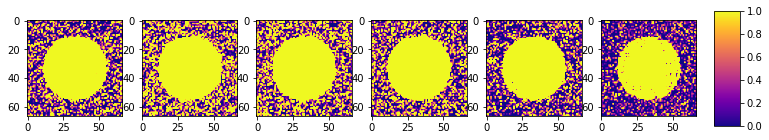

reference cube shape =  (6, 67, 67)
Building components one by one...
	1 of 6
Current Chi2=1.4205, Previous Chi2=78.4175, Change=98.1886% @ niters=0
Took 0.000 minutes to reach current solution.
	2 of 6
Current Chi2=1.2143, Previous Chi2=1.2166, Change=0.1912% @ niters=0
Current Chi2=1.1654, Previous Chi2=1.1716, Change=0.5257% @ niters=20
Current Chi2=0.9371, Previous Chi2=0.9536, Change=1.7334% @ niters=40
Current Chi2=0.6438, Previous Chi2=0.6531, Change=1.4219% @ niters=60
Current Chi2=0.5057, Previous Chi2=0.5109, Change=1.0170% @ niters=80
Current Chi2=0.4371, Previous Chi2=0.4393, Change=0.5146% @ niters=100
Current Chi2=0.4029, Previous Chi2=0.4043, Change=0.3435% @ niters=120
Current Chi2=0.3787, Previous Chi2=0.3797, Change=0.2716% @ niters=140
Current Chi2=0.3636, Previous Chi2=0.3641, Change=0.1447% @ niters=160
Current Chi2=0.3558, Previous Chi2=0.3561, Change=0.0878% @ niters=180
Current Chi2=0.3502, Previous Chi2=0.3505, Change=0.0719% @ niters=200
Current Chi2=0.3456, P

Current Chi2=0.1366, Previous Chi2=0.1366, Change=0.0085% @ niters=300
Current Chi2=0.1364, Previous Chi2=0.1364, Change=0.0086% @ niters=320
Current Chi2=0.1361, Previous Chi2=0.1361, Change=0.0108% @ niters=340
Current Chi2=0.1357, Previous Chi2=0.1358, Change=0.0191% @ niters=360
Current Chi2=0.1350, Previous Chi2=0.1351, Change=0.0307% @ niters=380
Current Chi2=0.1343, Previous Chi2=0.1343, Change=0.0238% @ niters=400
Current Chi2=0.1338, Previous Chi2=0.1338, Change=0.0157% @ niters=420
Current Chi2=0.1334, Previous Chi2=0.1334, Change=0.0138% @ niters=440
Current Chi2=0.1330, Previous Chi2=0.1330, Change=0.0122% @ niters=460
Current Chi2=0.1327, Previous Chi2=0.1327, Change=0.0102% @ niters=480
Current Chi2=0.1325, Previous Chi2=0.1325, Change=0.0087% @ niters=500
Current Chi2=0.1323, Previous Chi2=0.1323, Change=0.0079% @ niters=520
Current Chi2=0.1321, Previous Chi2=0.1321, Change=0.0075% @ niters=540
Current Chi2=0.1319, Previous Chi2=0.1319, Change=0.0073% @ niters=560
Curren

Current Chi2=0.0055, Previous Chi2=0.0056, Change=0.1382% @ niters=560
Current Chi2=0.0054, Previous Chi2=0.0054, Change=0.1204% @ niters=580
Current Chi2=0.0053, Previous Chi2=0.0053, Change=0.0998% @ niters=600
Current Chi2=0.0052, Previous Chi2=0.0052, Change=0.0861% @ niters=620
Current Chi2=0.0051, Previous Chi2=0.0051, Change=0.0787% @ niters=640
Current Chi2=0.0050, Previous Chi2=0.0050, Change=0.0747% @ niters=660
Current Chi2=0.0050, Previous Chi2=0.0050, Change=0.0726% @ niters=680
Current Chi2=0.0049, Previous Chi2=0.0049, Change=0.0730% @ niters=700
Current Chi2=0.0048, Previous Chi2=0.0048, Change=0.0845% @ niters=720
Current Chi2=0.0047, Previous Chi2=0.0047, Change=0.1458% @ niters=740
Current Chi2=0.0045, Previous Chi2=0.0045, Change=0.3193% @ niters=760
Current Chi2=0.0042, Previous Chi2=0.0042, Change=0.3186% @ niters=780
Current Chi2=0.0040, Previous Chi2=0.0040, Change=0.1353% @ niters=800
Current Chi2=0.0039, Previous Chi2=0.0039, Change=0.0872% @ niters=820
Curren

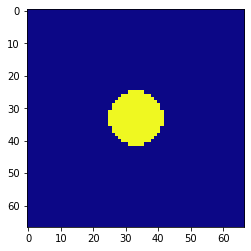

In [25]:
import nmf_imaging

refbox = np.zeros([6,67,67])
refbox[0] = dataID1
refbox[1] = dataID6
refbox[2] = dataID7
refbox[3] = dataID12
refbox[4] = dataID13
refbox[5] = dataID18
refbox *= 1


vmin = 0
vmax = 1
fig,ax = plt.subplots(ncols=6,figsize=[12,4])
ax[0].imshow(refbox[0],vmin=vmin,vmax=vmax)
ax[1].imshow(refbox[1],vmin=vmin,vmax=vmax)
ax[2].imshow(refbox[2],vmin=vmin,vmax=vmax)
ax[3].imshow(refbox[3],vmin=vmin,vmax=vmax)
ax[4].imshow(refbox[4],vmin=vmin,vmax=vmax)
cmap = ax[5].imshow(refbox[5],vmin=vmin,vmax=vmax)
cbax = fig.add_axes([0.92,0.3,0.03,0.4])
cb = plt.colorbar(cmap,cax=cbax)

plt.show()
mask = np.zeros([67,67])
x = np.linspace(-1,1,67)
y = x
x,y = np.meshgrid(x,y)
r = np.sqrt(x**2 + y**2)
mask[r <= 0.25] = 1
plt.imshow(mask)

print('reference cube shape = ',refbox.shape)


components = nmf_imaging.NMFcomponents(refbox,mask=mask,oneByOne=True)

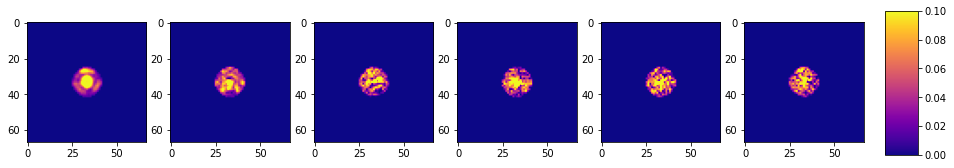

In [28]:
vmin = 0
vmax = 1e-1
fig,ax = plt.subplots(ncols=6,figsize=[15,5])
plt.set_cmap('plasma')
ax[0].imshow(components[0],vmin=vmin,vmax=vmax)
ax[1].imshow(components[1],vmin=vmin,vmax=vmax)
ax[2].imshow(components[2],vmin=vmin,vmax=vmax)
ax[3].imshow(components[3],vmin=vmin,vmax=vmax)
ax[4].imshow(components[4],vmin=vmin,vmax=vmax)
cmap = ax[5].imshow(components[5],vmin=vmin,vmax=vmax)
cbax = fig.add_axes([0.92,0.3,0.03,0.4])
cb = plt.colorbar(cmap,cax=cbax)

plt.show()

In [29]:
m11box = np.zeros([6,67,67])
m11box[0] = dataID2
m11box[1] = dataID4
m11box[2] = dataID9
m11box[3] = dataID11
m11box[4] = dataID14
m11box[5] = dataID16

results = np.zeros(m11box.shape)
for i in range(results.shape[0]):
    trg = m11box[i]
#     trg_err = np.sqrt(trg)
    model = nmf_imaging.NMFmodelling(trg=trg,components=components)
    best_frac = nmf_imaging.NMFbff(trg,model)
    result = nmf_imaging.NMFsubtraction(trg,model)
    results[i] = result

Current Chi2=0.0000, Previous Chi2=0.0009, Change=100.0000% @ niters=0


ValueError: NMF construction failed, likely due to missing data